# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    x_scaled = StandardScaler().fit_transform(x.values)    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map)

## Read Data

In [3]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.head(5)

,tick_avg,spread_avg,tick_sd,diff,gain,loss,avg_gain,avg_loss,rs,rsi,...,lsma,lsma_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,small_sema_slope,long_sema_slope,direction
0,1.146322,0.000234,0.000011,-0.000009,0.00000,0.000009,0.000007,0.000010,0.726481,42.078708,...,1.146357,-0.000002,-0.000046,1.146361,1.146198,0.000039,-0.000124,4.834632,-27.371543,same
1,1.146271,0.000306,0.000015,-0.000051,0.00000,0.000051,0.000007,0.000011,0.686985,40.722656,...,1.146353,-0.000005,-0.000037,1.146361,1.146224,0.000090,-0.000047,5.427201,-27.262714,same
2,1.146260,0.000335,0.000007,-0.000011,0.00000,0.000011,0.000007,0.000012,0.597542,37.403846,...,1.146350,-0.000003,-0.000033,1.146361,1.146228,0.000101,-0.000032,4.719563,-27.435594,same
3,1.146310,0.000254,0.000028,0.000050,0.00005,0.000000,0.000010,0.000012,0.881720,46.857143,...,1.146342,-0.000008,-0.000021,1.146361,1.146260,0.000052,-0.000050,3.226806,-26.665381,same
4,1.146294,0.000307,0.000028,-0.000015,0.00000,0.000015,0.000010,0.000009,1.205882,54.666667,...,1.146334,-0.000008,-0.000015,1.146361,1.146260,0.000067,-0.000035,1.794724,-25.345654,same


In [4]:
target_col = 'direction'
x_scaled, y_encoded, y_map = data_prep(df)

Record count : 1459266
--------------------------
same        1035732
decrease     213280
increase     210254
Name: direction, dtype: int64
--------------------------
same        0.709762
decrease    0.146156
increase    0.144082
Name: direction, dtype: float64


## Neural Network

### Network building

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [6]:
model = Sequential([
    Dense(units = 32, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 64, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    Dense(units = 16, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 20,643
Trainable params: 20,643
Non-trainable params: 0
____________________________________________________

### Training

In [7]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [8]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/10
1141/1141 - 3s - loss: 0.3007 - accuracy: 0.8755 - val_loss: 0.2787 - val_accuracy: 0.8833
Epoch 2/10
1141/1141 - 3s - loss: 0.2730 - accuracy: 0.8854 - val_loss: 0.2724 - val_accuracy: 0.8868
Epoch 3/10
1141/1141 - 3s - loss: 0.2709 - accuracy: 0.8862 - val_loss: 0.2711 - val_accuracy: 0.8865
Epoch 4/10
1141/1141 - 3s - loss: 0.2703 - accuracy: 0.8867 - val_loss: 0.2725 - val_accuracy: 0.8860
Epoch 5/10
1141/1141 - 3s - loss: 0.2694 - accuracy: 0.8870 - val_loss: 0.2693 - val_accuracy: 0.8877
Epoch 6/10
1141/1141 - 3s - loss: 0.2692 - accuracy: 0.8871 - val_loss: 0.2707 - val_accuracy: 0.8869
Epoch 7/10
1141/1141 - 3s - loss: 0.2690 - accuracy: 0.8872 - val_loss: 0.2694 - val_accuracy: 0.8876
Epoch 8/10
1141/1141 - 3s - loss: 0.2686 - accuracy: 0.8873 - val_loss: 0.2692 - val_accuracy: 0.8876
Epoch 9/10
1141/1141 - 3s - loss: 0.2684 - accuracy: 0.8874 - val_loss: 0.2726 - val_accuracy: 0.8853
Epoch 10/10
1141/1141 - 3s - loss: 0.2682 - accuracy: 0.8875 - val_loss: 0.2686 - 

### DNN Validation

In [9]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.84      0.76      0.80     42463
    increase       0.82      0.77      0.80     42134
        same       0.91      0.94      0.92    207257

    accuracy                           0.89    291854
   macro avg       0.86      0.82      0.84    291854
weighted avg       0.89      0.89      0.89    291854



### DNN Prediction

In [10]:
df1 = pd.read_csv('data/tab_tick_2017.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1 = data_prep(df1, apply_smote = False)

predictions = model.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2017_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

Record count : 1085153
--------------------------
same        553625
increase    267251
decrease    264277
Name: direction, dtype: int64
--------------------------
same        0.510182
increase    0.246280
decrease    0.243539
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.96      0.50      0.66    264277
    increase       0.96      0.50      0.66    267251
        same       0.67      0.98      0.80    553625

    accuracy                           0.74   1085153
   macro avg       0.86      0.66      0.70   1085153
weighted avg       0.81      0.74      0.73   1085153



## RF Results

In [11]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.82      0.77      0.79     42463
    increase       0.83      0.76      0.79     42134
        same       0.91      0.94      0.92    207257

    accuracy                           0.88    291854
   macro avg       0.85      0.82      0.83    291854
weighted avg       0.88      0.88      0.88    291854

Wall time: 3min 32s


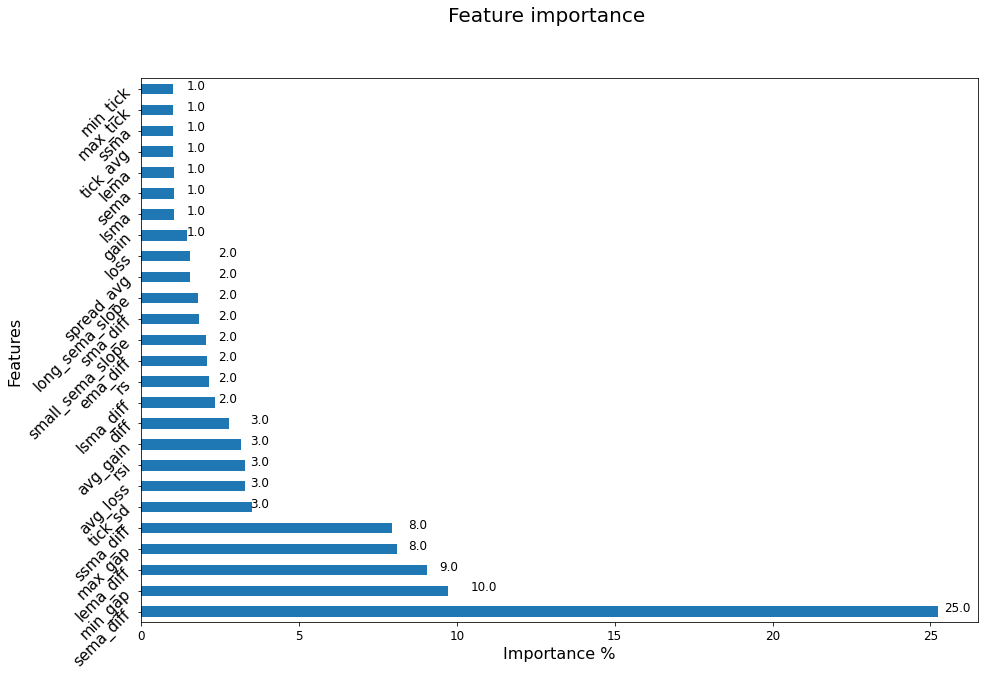

In [12]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)